# Rt profile multicategorical versus uniform

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

num_timepoints = 200 # number of days for incidence data
num_categories = 2

# Same Serial Interval

## Parameterize example branching process model with disagregated data

In [2]:
# Build the serial interval w_s
serial_intervals = []

ws_mean_cat = [5.3, 5.3]
ws_std_cat = [2.3, 2.3]

for ws_mean, ws_std in zip(ws_mean_cat, ws_std_cat):
    theta = ws_std**2 / ws_mean
    k = ws_mean / theta
    w_dist = scipy.stats.gamma(k, scale=theta)
    disc_w = w_dist.pdf(np.arange(30))

    serial_intervals.append(disc_w)

serial_intervals = np.array(serial_intervals)

average_serial_interval = np.mean(serial_intervals, axis=0)

# Simulate incidence data
initial_r = 0.35

contact_matrix = [
    np.array([[10., 1.], [1., 0]]),
    np.array([[0., 10.], [5., 4.]]),
    np.array([[10., 1.], [1., 0]]),
    np.array([[10., 1.], [1., 0]])
    ]

new_rs = [
    [0.35, 0.05, 0.4, 0.05],
    [0.35, 0.05, 0.4, 0.05],
    [0.35, 0.05, 0.2, 0.1],
    [0.35, 0.05, 0.4, 0.05]
    ]

parameters = [
    [50, 50],
    [50, 50],
    [50, 50],
    [20, 80],
    ]

transmissibility = [1, 1]

desagg_cases = []
agg_cases = []

for _ in range(len(contact_matrix)):
    m = branchpro.MultiCatPoissonBranchProModel(
        initial_r, serial_intervals, num_categories, contact_matrix[_], transmissibility, multipleSI=True)
    start_times = [0, 37, 60, 160]      # days at which each R_0 period begins
    m.set_r_profile(new_rs[_], start_times)
    times = np.arange(num_timepoints)

    desagg_cases.append(m.simulate(parameters[_], times, var_contacts=False))
    agg_cases.append(np.sum(desagg_cases[_], axis=1))

    print(desagg_cases[_])

[[5.00000000e+01 5.00000000e+01]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [1.40000000e+01 0.00000000e+00]
 [3.50000000e+01 1.00000000e+00]
 [3.40000000e+01 3.00000000e+00]
 [3.80000000e+01 4.00000000e+00]
 [4.20000000e+01 5.00000000e+00]
 [4.70000000e+01 5.00000000e+00]
 [7.80000000e+01 6.00000000e+00]
 [8.20000000e+01 1.30000000e+01]
 [1.09000000e+02 1.00000000e+01]
 [1.26000000e+02 1.10000000e+01]
 [1.51000000e+02 1.60000000e+01]
 [2.19000000e+02 2.00000000e+01]
 [2.36000000e+02 2.10000000e+01]
 [2.85000000e+02 4.00000000e+01]
 [4.01000000e+02 4.40000000e+01]
 [4.61000000e+02 4.90000000e+01]
 [5.86000000e+02 5.80000000e+01]
 [7.56000000e+02 7.20000000e+01]
 [9.00000000e+02 9.50000000e+01]
 [1.12200000e+03 1.07000000e+02]
 [1.42200000e+03 1.22000000e+02]
 [1.72500000e+03 1.79000000e+02]
 [2.09000000e+03 2.21000000e+02]
 [2.73100000e+03 2.67000000e+02]
 [3.25500000e+03 3.28000000e+02]
 [4.22000000e+03 3.95000000e+02]
 [5.06700000e+03 5.07000000e+02]
 [6.156000

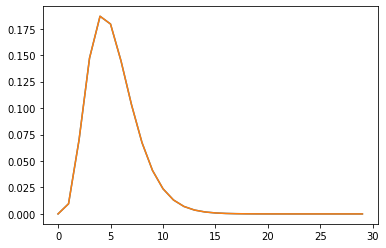

In [3]:
plt.plot(serial_intervals[0, :])
plt.plot(serial_intervals[1, :])

## Plot agreggated local incidence numbers

In [4]:
for _ in range(len(contact_matrix)):  
    # Plot (bar chart cases each day)
    fig = go.Figure()

    # Plot of incidences
    fig.add_trace(
        go.Bar(
            x=times,
            y=agg_cases[_],
            name='Incidences'
        )
    )

    # Add axis labels
    fig.update_layout(
        xaxis_title='Time (days)',
        yaxis_title='New cases'
    )

    fig.show()

In [5]:
spec_radius = []
stability_criterion = []

for _ in range(len(contact_matrix)):    
    # Compute the eigenvalues of the maximum effective contact matrix
    eff_contact_matrix = np.matmul(contact_matrix[_], np.diag(transmissibility))

    spec_radius.append(np.max(np.absolute(np.linalg.eigvals(eff_contact_matrix))))

    # Compute stability criterion using last change in growth rate
    stability_criterion.append(new_rs[_][-1] * spec_radius[_])

    print(stability_criterion[_], spec_radius[_])

0.5049509756796393 10.099019513592786
0.46742346141747665 9.348469228349533
1.0099019513592786 10.099019513592786
0.5049509756796393 10.099019513592786


In [6]:
correc_i = []

for _ in range(len(contact_matrix)):
    # Same inference, but using the PoissonBranchProPosterior
    tau = 6
    R_t_start = tau+1
    a = 1
    b = 1/5
    sigma = 1.5

    # Correction for overall reproduction number
    # Imperfect contacts
    eff_contact_matrix = np.matmul(contact_matrix[_], np.diag(transmissibility))
    correc_i.append(np.max(np.absolute(np.linalg.eigvals(eff_contact_matrix))))

In [7]:
inc_data = []
ground_truth = []

for _ in range(len(contact_matrix)):
    # Transform our incidence data into pandas dataframes
    multicat_inc_data_matrix = {'Time': np.arange(num_timepoints)}

    for _ in range(num_categories):
        multicat_inc_data_matrix['Incidence Number Cat {}'.format(_+1)] = \
            desagg_cases[_][:, _]

    multicat_inc_data = pd.DataFrame(multicat_inc_data_matrix)

    # Transform our incidence data into pandas dataframes
    inc_data.append(pd.DataFrame(
        {
            'Time': np.arange(num_timepoints),
            'Incidence Number': agg_cases[_]
        }
    ))

    L1 = len(np.arange(R_t_start, start_times[1]+1))
    L2 = len(np.arange(start_times[1]+1, start_times[2]+1))
    L3 = len(np.arange(start_times[2]+1, start_times[3]+1))
    L4 = len(np.arange(start_times[3]+1, num_timepoints))

    ground_truth.append(pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'R_t': [new_rs[_][0]*correc_i[_]] * L1 + [new_rs[_][1]*correc_i[_]] * L2 + [new_rs[_][2]*correc_i[_]] * L3 + [new_rs[_][3]*correc_i[_]] * L4
    }))

## Divergence of Means

In [8]:
uni_post_dist = []
multi_post_dist = []

for _ in range(len(contact_matrix)):
    mean_ratios = []
    uni_rate = []
    multi_rate = []
    shape = []
    for t in np.arange(R_t_start, num_timepoints):
        shape.append( a + math.fsum(agg_cases[_][(t-tau):(t+1)]))
        uni_cat_sum_var = 0
        for k in range(t-tau,t+1):
            if k > len(average_serial_interval):
                vec1 = agg_cases[_][(k-1):(k - len(average_serial_interval) - 1):-1] # I_(k-1), ... , I_0
                vec2 = average_serial_interval[:k] # w_1, ... , w_k
            else:
                vec1 = agg_cases[_][(k-1)::-1] # I_(k-1), ... , I_0
                vec2 = average_serial_interval[:k] # w_1, ... , w_k
            uni_cat_sum_var += math.fsum(np.multiply(vec1,vec2))/np.sum(average_serial_interval)
        uni_cat_rate = b + uni_cat_sum_var

        multi_cat_sum_var = 0
        for k_inx, k in enumerate(range(t-tau,t+1)):
            sub_sum_i = 0
            for i in range(num_categories):
                for j in range(num_categories):
                    if k > serial_intervals.shape[1]:
                        vec1 = desagg_cases[_][(k-1):(k - serial_intervals.shape[1] - 1):-1, j] # I_(k-1), ... , I_0
                        vec2 = serial_intervals[j, :k] # w_1, ... , w_k
                    else:
                        vec1 = desagg_cases[_][(k-1)::-1, j] # I_(k-1), ... , I_0
                        vec2 = serial_intervals[j, :k] # w_1, ... , w_k
                    sub_sum_j = math.fsum(np.multiply(vec1,vec2))/np.sum(serial_intervals[j,:])
                    sub_sum_j *= contact_matrix[_][i, j] * transmissibility[j]
                    sub_sum_i += sub_sum_j
            multi_cat_sum_var += sub_sum_i  # vector of sum^k_{s=0} w_s I_{k-s}
            # print(multi_cat_sum_var)
        multi_cat_rate = b + (multi_cat_sum_var/spec_radius[_])

        mean_ratios.append(uni_cat_rate / multi_cat_rate)
        uni_rate.append(uni_cat_rate)
        multi_rate.append(multi_cat_rate)

    mean_ratio = pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'R_t': 100 * np.asarray(mean_ratios)
    })

    # Tests
    i + tau == num_timepoints
    len(shape) == num_timepoints - tau
    len(uni_rate) == num_timepoints - tau
    len(multi_rate) == num_timepoints - tau

    mean_uni = np.divide(shape, uni_rate)
    mean_multi = np.divide(shape, multi_rate)

    uni_post_dist.append(scipy.stats.gamma(shape,scale = 1/np.array(uni_rate)))
    uni_post_dist_interval = uni_post_dist[_].interval(.95)

    multi_post_dist.append(scipy.stats.gamma(shape,scale = 1/np.array(multi_rate)))
    multi_post_dist_interval = multi_post_dist[_].interval(.95)

    fig = ReproductionNumberPlot()

    fig.add_ground_truth_rt(mean_ratio)    
    fig.update_labels(time_label='Time (Day)', r_label='Ratio(%)')
    fig.figure.update_layout(title_text='Multi-categorical versus Standard')

    fig.show_figure()

In [9]:
subplot_titles = ['Original', 'Changed Contacts', 'Changed r', 'Changed ICs']

fig = go.Figure()
fig = make_subplots(rows=int(np.ceil(len(contact_matrix)/2)), cols=2, subplot_titles=tuple(subplot_titles))
# Plot (line plot for each age group and method of simulation)
for c in range(len(contact_matrix)):
    if c != 0:
        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='Unicategorical model',
                line_color='deepskyblue',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='Multicategorical model',
                line_color='red',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )
    
    else:
        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='Unicategorical model',
                line_color='deepskyblue'
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='Multicategorical model',
                line_color='red'
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

# Add axis labels
fig.update_layout(
    boxmode='group',
    title='Same serial interval', 
    width=700,
    height=600,
    plot_bgcolor='white',
    xaxis=dict(linecolor='black'),
    yaxis=dict(linecolor='black', range=[0, 6]),
    xaxis2=dict(linecolor='black'),
    yaxis2=dict(linecolor='black', range=[0, 6]),
    xaxis3=dict(linecolor='black'),
    yaxis3=dict(linecolor='black', range=[0, 6]),
    xaxis4=dict(linecolor='black'),
    yaxis4=dict(linecolor='black', range=[0, 6]),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=1
    ))

fig.write_image('images/Comparison_same_SI.pdf')
fig.show()

# Different Serial Intervals

## Parameterize example branching process model with disagregated data

In [10]:
# Build the serial interval w_s
serial_intervals = []

ws_mean_cat = [5.3, 7]
ws_std_cat = [2.3, 2.3]

for ws_mean, ws_std in zip(ws_mean_cat, ws_std_cat):
    theta = ws_std**2 / ws_mean
    k = ws_mean / theta
    w_dist = scipy.stats.gamma(k, scale=theta)
    disc_w = w_dist.pdf(np.arange(30))

    serial_intervals.append(disc_w)

serial_intervals = np.array(serial_intervals)

average_serial_interval = np.mean(serial_intervals, axis=0)

# Simulate incidence data
initial_r = 0.35

contact_matrix = [
    np.array([[10., 1.], [1., 0]]),
    np.array([[0., 10.], [5., 4.]]),
    np.array([[10., 1.], [1., 0]]),
    np.array([[10., 1.], [1., 0]])
    ]

new_rs = [
    [0.35, 0.05, 0.4, 0.05],
    [0.35, 0.05, 0.4, 0.05],
    [0.35, 0.05, 0.2, 0.1],
    [0.35, 0.05, 0.4, 0.05]
    ]

parameters = [
    [50, 50],
    [50, 50],
    [50, 50],
    [20, 80],
    ]

transmissibility = [1, 1]

desagg_cases = []
agg_cases = []

for _ in range(len(contact_matrix)):
    m = branchpro.MultiCatPoissonBranchProModel(
        initial_r, serial_intervals, num_categories, contact_matrix[_], transmissibility, multipleSI=True)
    start_times = [0, 37, 60, 160]      # days at which each R_0 period begins
    m.set_r_profile(new_rs[_], start_times)
    times = np.arange(num_timepoints)

    desagg_cases.append(m.simulate(parameters[_], times, var_contacts=False))
    agg_cases.append(np.sum(desagg_cases[_], axis=1))

    print(desagg_cases[_])

[[5.00000000e+01 5.00000000e+01]
 [0.00000000e+00 0.00000000e+00]
 [3.00000000e+00 0.00000000e+00]
 [1.40000000e+01 2.00000000e+00]
 [2.20000000e+01 6.00000000e+00]
 [3.40000000e+01 4.00000000e+00]
 [5.20000000e+01 0.00000000e+00]
 [4.20000000e+01 2.00000000e+00]
 [5.10000000e+01 6.00000000e+00]
 [8.50000000e+01 8.00000000e+00]
 [8.40000000e+01 1.10000000e+01]
 [9.40000000e+01 1.10000000e+01]
 [1.55000000e+02 1.40000000e+01]
 [1.82000000e+02 1.70000000e+01]
 [2.10000000e+02 1.80000000e+01]
 [2.74000000e+02 2.30000000e+01]
 [3.31000000e+02 2.60000000e+01]
 [3.98000000e+02 4.90000000e+01]
 [4.81000000e+02 4.70000000e+01]
 [6.18000000e+02 5.20000000e+01]
 [7.75000000e+02 5.90000000e+01]
 [9.62000000e+02 8.50000000e+01]
 [1.19200000e+03 1.14000000e+02]
 [1.47100000e+03 1.53000000e+02]
 [1.74300000e+03 2.00000000e+02]
 [2.24300000e+03 2.43000000e+02]
 [2.87100000e+03 2.98000000e+02]
 [3.53700000e+03 3.65000000e+02]
 [4.50300000e+03 4.51000000e+02]
 [5.29900000e+03 5.58000000e+02]
 [6.640000

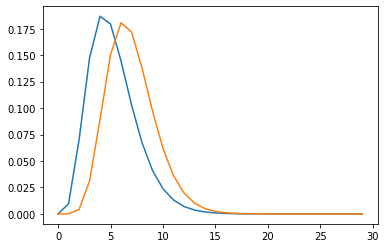

In [11]:
plt.plot(serial_intervals[0, :])
plt.plot(serial_intervals[1, :])

## Plot agreggated local incidence numbers

In [12]:
for _ in range(len(contact_matrix)):  
    # Plot (bar chart cases each day)
    fig = go.Figure()

    # Plot of incidences
    fig.add_trace(
        go.Bar(
            x=times,
            y=agg_cases[_],
            name='Incidences'
        )
    )

    # Add axis labels
    fig.update_layout(
        xaxis_title='Time (days)',
        yaxis_title='New cases'
    )

    fig.show()

In [13]:
spec_radius = []
stability_criterion = []

for _ in range(len(contact_matrix)):    
    # Compute the eigenvalues of the maximum effective contact matrix
    eff_contact_matrix = np.matmul(contact_matrix[_], np.diag(transmissibility))

    spec_radius.append(np.max(np.absolute(np.linalg.eigvals(eff_contact_matrix))))

    # Compute stability criterion using last change in growth rate
    stability_criterion.append(new_rs[_][-1] * spec_radius[_])

    print(stability_criterion[_], spec_radius[_])

0.5049509756796393 10.099019513592786
0.46742346141747665 9.348469228349533
1.0099019513592786 10.099019513592786
0.5049509756796393 10.099019513592786


In [14]:
correc_i = []

for _ in range(len(contact_matrix)):
    # Same inference, but using the PoissonBranchProPosterior
    tau = 6
    R_t_start = tau+1
    a = 1
    b = 1/5
    sigma = 1.5

    # Correction for overall reproduction number
    # Imperfect contacts
    eff_contact_matrix = np.matmul(contact_matrix[_], np.diag(transmissibility))
    correc_i.append(np.max(np.absolute(np.linalg.eigvals(eff_contact_matrix))))

In [15]:
inc_data = []
ground_truth = []

for _ in range(len(contact_matrix)):
    # Transform our incidence data into pandas dataframes
    multicat_inc_data_matrix = {'Time': np.arange(num_timepoints)}

    for _ in range(num_categories):
        multicat_inc_data_matrix['Incidence Number Cat {}'.format(_+1)] = \
            desagg_cases[_][:, _]

    multicat_inc_data = pd.DataFrame(multicat_inc_data_matrix)

    # Transform our incidence data into pandas dataframes
    inc_data.append(pd.DataFrame(
        {
            'Time': np.arange(num_timepoints),
            'Incidence Number': agg_cases[_]
        }
    ))

    L1 = len(np.arange(R_t_start, start_times[1]+1))
    L2 = len(np.arange(start_times[1]+1, start_times[2]+1))
    L3 = len(np.arange(start_times[2]+1, start_times[3]+1))
    L4 = len(np.arange(start_times[3]+1, num_timepoints))

    ground_truth.append(pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'R_t': [new_rs[_][0]*correc_i[_]] * L1 + [new_rs[_][1]*correc_i[_]] * L2 + [new_rs[_][2]*correc_i[_]] * L3 + [new_rs[_][3]*correc_i[_]] * L4
    }))

## Divergence of Means

In [16]:
uni_post_dist = []
multi_post_dist = []

for _ in range(len(contact_matrix)):
    mean_ratios = []
    uni_rate = []
    multi_rate = []
    shape = []
    for t in np.arange(R_t_start, num_timepoints):
        shape.append( a + math.fsum(agg_cases[_][(t-tau):(t+1)]))
        uni_cat_sum_var = 0
        for k in range(t-tau,t+1):
            if k > len(average_serial_interval):
                vec1 = agg_cases[_][(k-1):(k - len(average_serial_interval) - 1):-1] # I_(k-1), ... , I_0
                vec2 = average_serial_interval[:k] # w_1, ... , w_k
            else:
                vec1 = agg_cases[_][(k-1)::-1] # I_(k-1), ... , I_0
                vec2 = average_serial_interval[:k] # w_1, ... , w_k
            uni_cat_sum_var += math.fsum(np.multiply(vec1,vec2))/np.sum(average_serial_interval)
        uni_cat_rate = b + uni_cat_sum_var

        multi_cat_sum_var = 0
        for k_inx, k in enumerate(range(t-tau,t+1)):
            sub_sum_i = 0
            for i in range(num_categories):
                for j in range(num_categories):
                    if k > serial_intervals.shape[1]:
                        vec1 = desagg_cases[_][(k-1):(k - serial_intervals.shape[1] - 1):-1, j] # I_(k-1), ... , I_0
                        vec2 = serial_intervals[j, :k] # w_1, ... , w_k
                    else:
                        vec1 = desagg_cases[_][(k-1)::-1, j] # I_(k-1), ... , I_0
                        vec2 = serial_intervals[j, :k] # w_1, ... , w_k
                    sub_sum_j = math.fsum(np.multiply(vec1,vec2))/np.sum(serial_intervals[j,:])
                    sub_sum_j *= contact_matrix[_][i, j] * transmissibility[j]
                    sub_sum_i += sub_sum_j
            multi_cat_sum_var += sub_sum_i  # vector of sum^k_{s=0} w_s I_{k-s}
            # print(multi_cat_sum_var)
        multi_cat_rate = b + (multi_cat_sum_var/spec_radius[_])

        mean_ratios.append(uni_cat_rate / multi_cat_rate)
        uni_rate.append(uni_cat_rate)
        multi_rate.append(multi_cat_rate)

    mean_ratio = pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'R_t': 100 * np.asarray(mean_ratios)
    })

    # Tests
    i + tau == num_timepoints
    len(shape) == num_timepoints - tau
    len(uni_rate) == num_timepoints - tau
    len(multi_rate) == num_timepoints - tau

    mean_uni = np.divide(shape, uni_rate)
    mean_multi = np.divide(shape, multi_rate)

    uni_post_dist.append(scipy.stats.gamma(shape,scale = 1/np.array(uni_rate)))
    uni_post_dist_interval = uni_post_dist[_].interval(.95)

    multi_post_dist.append(scipy.stats.gamma(shape,scale = 1/np.array(multi_rate)))
    multi_post_dist_interval = multi_post_dist[_].interval(.95)

    fig = ReproductionNumberPlot()

    fig.add_ground_truth_rt(mean_ratio)    
    fig.update_labels(time_label='Time (Day)', r_label='Ratio(%)')
    fig.figure.update_layout(title_text='Multi-categorical versus Standard')

    fig.show_figure()

In [17]:
subplot_titles = ['Original', 'Changed Contacts', 'Changed r', 'Changed ICs']

fig = go.Figure()
fig = make_subplots(rows=int(np.ceil(len(contact_matrix)/2)), cols=2, subplot_titles=tuple(subplot_titles))
# Plot (line plot for each age group and method of simulation)
for c in range(len(contact_matrix)):
    if c != 0:
        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='Unicategorical model',
                line_color='deepskyblue',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='Multicategorical model',
                line_color='red',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )
    
    else:
        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='Unicategorical model',
                line_color='deepskyblue'
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='Multicategorical model',
                line_color='red'
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

# Add axis labels
fig.update_layout(
    boxmode='group',
    title='Different serial intervals', 
    width=700,
    height=600,
    plot_bgcolor='white',
    xaxis=dict(linecolor='black'),
    yaxis=dict(linecolor='black', range=[0, 6]),
    xaxis2=dict(linecolor='black'),
    yaxis2=dict(linecolor='black', range=[0, 6]),
    xaxis3=dict(linecolor='black'),
    yaxis3=dict(linecolor='black', range=[0, 6]),
    xaxis4=dict(linecolor='black'),
    yaxis4=dict(linecolor='black', range=[0, 6]),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=1
    ))

fig.write_image('images/Comparison_dif_SI.pdf')
fig.show()

# Different Serial Intervals, cropped

## Parameterize example branching process model with disagregated data

In [18]:
# Build the serial interval w_s
serial_intervals = []

ws_mean_cat = [5.3, 5.3]
ws_std_cat = [2.3, 2.3]
crop_cat = [30, 5]

for ws_mean, ws_std, crop in zip(ws_mean_cat, ws_std_cat, crop_cat):
    theta = ws_std**2 / ws_mean
    k = ws_mean / theta
    w_dist = scipy.stats.gamma(k, scale=theta)
    disc_w = w_dist.pdf(np.arange(crop))
    disc_w = np.array(disc_w.tolist() + [0]*(30-crop))

    serial_intervals.append(disc_w)

serial_intervals = np.array(serial_intervals)

average_serial_interval = np.mean(serial_intervals, axis=0)

# Simulate incidence data
initial_r = 0.35

contact_matrix = [
    np.array([[10., 1.], [1., 0]]),
    np.array([[0., 10.], [5., 4.]]),
    np.array([[10., 1.], [1., 0]]),
    np.array([[10., 1.], [1., 0]])
    ]

new_rs = [
    [0.35, 0.05, 0.4, 0.05],
    [0.35, 0.05, 0.4, 0.05],
    [0.35, 0.05, 0.2, 0.1],
    [0.35, 0.05, 0.4, 0.05]
    ]

parameters = [
    [50, 50],
    [50, 50],
    [50, 50],
    [20, 80],
    ]

transmissibility = [1, 1]

desagg_cases = []
agg_cases = []

for _ in range(len(contact_matrix)):
    m = branchpro.MultiCatPoissonBranchProModel(
        initial_r, serial_intervals, num_categories, contact_matrix[_], transmissibility, multipleSI=True)
    start_times = [0, 37, 60, 160]      # days at which each R_0 period begins
    m.set_r_profile(new_rs[_], start_times)
    # m._normalizing_const[1] *= np.sum(serial_intervals[0,:]) / np.sum(serial_intervals[1,:])
    times = np.arange(num_timepoints)

    desagg_cases.append(m.simulate(parameters[_], times, var_contacts=False))
    agg_cases.append(np.sum(desagg_cases[_], axis=1))

    print(desagg_cases[_])

[[5.00000000e+01 5.00000000e+01]
 [0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.70000000e+01 0.00000000e+00]
 [3.30000000e+01 4.00000000e+00]
 [2.50000000e+01 1.00000000e+00]
 [4.10000000e+01 3.00000000e+00]
 [3.70000000e+01 5.00000000e+00]
 [6.00000000e+01 5.00000000e+00]
 [6.70000000e+01 8.00000000e+00]
 [8.00000000e+01 6.00000000e+00]
 [1.02000000e+02 1.00000000e+01]
 [1.39000000e+02 9.00000000e+00]
 [1.55000000e+02 2.30000000e+01]
 [2.16000000e+02 2.60000000e+01]
 [2.43000000e+02 1.80000000e+01]
 [3.12000000e+02 4.00000000e+01]
 [4.14000000e+02 4.40000000e+01]
 [4.85000000e+02 5.00000000e+01]
 [6.24000000e+02 6.20000000e+01]
 [7.27000000e+02 7.70000000e+01]
 [9.84000000e+02 8.80000000e+01]
 [1.18600000e+03 1.17000000e+02]
 [1.45800000e+03 1.48000000e+02]
 [1.83200000e+03 2.10000000e+02]
 [2.32200000e+03 2.24000000e+02]
 [2.80500000e+03 2.90000000e+02]
 [3.51000000e+03 3.23000000e+02]
 [4.41500000e+03 4.42000000e+02]
 [5.38000000e+03 5.86000000e+02]
 [6.881000

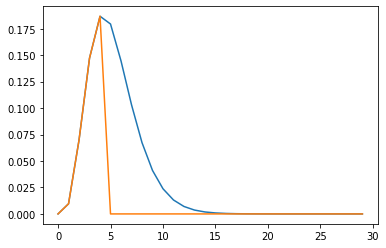

In [19]:
plt.plot(serial_intervals[0, :])
plt.plot(serial_intervals[1, :])

In [20]:
for j in range(m._num_cat):
    print(m.get_serial_intervals()[j, :] / m._normalizing_const[j])
    print(np.sum(m.get_serial_intervals()[j, :] / m._normalizing_const[j]))
    print(m._normalizing_const[j])

[0.00000000e+00 9.58764800e-03 6.98299287e-02 1.47191523e-01
 1.86747872e-01 1.79400725e-01 1.44537789e-01 1.03135430e-01
 6.73346823e-02 4.10763362e-02 2.37515466e-02 1.31516334e-02
 7.02641267e-03 3.64286883e-03 1.84096136e-03 9.10062622e-04
 4.41326648e-04 2.10437397e-04 9.88547589e-05 4.58232717e-05
 2.09885445e-05 9.51027657e-06 4.26731467e-06 1.89777533e-06
 8.37130511e-07 3.66512708e-07 1.59363037e-07 6.88517759e-08
 2.95714951e-08 1.26311348e-08]
0.9999999999999997
1.000037408024706
[0.         0.0231946  0.16893371 0.35608816 0.45178353 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
1.0
0.41337243447159694


## Plot agreggated local incidence numbers

In [21]:
for _ in range(len(contact_matrix)):  
    # Plot (bar chart cases each day)
    fig = go.Figure()

    # Plot of incidences
    fig.add_trace(
        go.Bar(
            x=times,
            y=agg_cases[_],
            name='Incidences'
        )
    )

    # Add axis labels
    fig.update_layout(
        xaxis_title='Time (days)',
        yaxis_title='New cases'
    )

    fig.show()

In [22]:
spec_radius = []
stability_criterion = []

for _ in range(len(contact_matrix)):    
    # Compute the eigenvalues of the maximum effective contact matrix
    eff_contact_matrix = np.matmul(contact_matrix[_], np.diag(transmissibility))

    spec_radius.append(np.max(np.absolute(np.linalg.eigvals(eff_contact_matrix))))

    # Compute stability criterion using last change in growth rate
    stability_criterion.append(new_rs[_][-1] * spec_radius[_])

    print(stability_criterion[_], spec_radius[_])

0.5049509756796393 10.099019513592786
0.46742346141747665 9.348469228349533
1.0099019513592786 10.099019513592786
0.5049509756796393 10.099019513592786


In [23]:
correc_i = []

for _ in range(len(contact_matrix)):
    # Same inference, but using the PoissonBranchProPosterior
    tau = 6
    R_t_start = tau+1
    a = 1
    b = 1/5
    sigma = 1.5

    # Correction for overall reproduction number
    # Imperfect contacts
    eff_contact_matrix = np.matmul(contact_matrix[_], np.diag(transmissibility))
    correc_i.append(np.max(np.absolute(np.linalg.eigvals(eff_contact_matrix))))

In [24]:
inc_data = []
ground_truth = []

for _ in range(len(contact_matrix)):
    # Transform our incidence data into pandas dataframes
    multicat_inc_data_matrix = {'Time': np.arange(num_timepoints)}

    for _ in range(num_categories):
        multicat_inc_data_matrix['Incidence Number Cat {}'.format(_+1)] = \
            desagg_cases[_][:, _]

    multicat_inc_data = pd.DataFrame(multicat_inc_data_matrix)

    # Transform our incidence data into pandas dataframes
    inc_data.append(pd.DataFrame(
        {
            'Time': np.arange(num_timepoints),
            'Incidence Number': agg_cases[_]
        }
    ))

    L1 = len(np.arange(R_t_start, start_times[1]+1))
    L2 = len(np.arange(start_times[1]+1, start_times[2]+1))
    L3 = len(np.arange(start_times[2]+1, start_times[3]+1))
    L4 = len(np.arange(start_times[3]+1, num_timepoints))

    ground_truth.append(pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'R_t': [new_rs[_][0]*correc_i[_]] * L1 + [new_rs[_][1]*correc_i[_]] * L2 + [new_rs[_][2]*correc_i[_]] * L3 + [new_rs[_][3]*correc_i[_]] * L4
    }))

## Divergence of Means

In [25]:
uni_post_dist = []
multi_post_dist = []

for _ in range(len(contact_matrix)):
    mean_ratios = []
    uni_rate = []
    multi_rate = []
    shape = []
    for t in np.arange(R_t_start, num_timepoints):
        shape.append( a + math.fsum(agg_cases[_][(t-tau):(t+1)]))
        uni_cat_sum_var = 0
        for k in range(t-tau,t+1):
            if k > len(average_serial_interval):
                vec1 = agg_cases[_][(k-1):(k - len(average_serial_interval) - 1):-1] # I_(k-1), ... , I_0
                vec2 = average_serial_interval[:k] # w_1, ... , w_k
            else:
                vec1 = agg_cases[_][(k-1)::-1] # I_(k-1), ... , I_0
                vec2 = average_serial_interval[:k] # w_1, ... , w_k
            uni_cat_sum_var += math.fsum(np.multiply(vec1,vec2))/np.sum(average_serial_interval)
        uni_cat_rate = b + uni_cat_sum_var

        multi_cat_sum_var = 0
        for k_inx, k in enumerate(range(t-tau,t+1)):
            sub_sum_i = 0
            for i in range(num_categories):
                for j in range(num_categories):
                    if k > serial_intervals.shape[1]:
                        vec1 = desagg_cases[_][(k-1):(k - serial_intervals.shape[1] - 1):-1, j] # I_(k-1), ... , I_0
                        vec2 = serial_intervals[j, :k] # w_1, ... , w_k
                    else:
                        vec1 = desagg_cases[_][(k-1)::-1, j] # I_(k-1), ... , I_0
                        vec2 = serial_intervals[j, :k] # w_1, ... , w_k
                    sub_sum_j = math.fsum(np.multiply(vec1,vec2))/(np.sum(serial_intervals[j,:])* np.sum(serial_intervals[0,:]) / np.sum(serial_intervals[j,:]))
                    sub_sum_j *= contact_matrix[_][i, j] * transmissibility[j]
                    sub_sum_i += sub_sum_j
            multi_cat_sum_var += sub_sum_i  # vector of sum^k_{s=0} w_s I_{k-s}
            # print(multi_cat_sum_var)
        multi_cat_rate = b + (multi_cat_sum_var/spec_radius[_])

        mean_ratios.append(uni_cat_rate / multi_cat_rate)
        uni_rate.append(uni_cat_rate)
        multi_rate.append(multi_cat_rate)

    mean_ratio = pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'R_t': 100 * np.asarray(mean_ratios)
    })

    # Tests
    i + tau == num_timepoints
    len(shape) == num_timepoints - tau
    len(uni_rate) == num_timepoints - tau
    len(multi_rate) == num_timepoints - tau

    mean_uni = np.divide(shape, uni_rate)
    mean_multi = np.divide(shape, multi_rate)

    uni_post_dist.append(scipy.stats.gamma(shape,scale = 1/np.array(uni_rate)))
    uni_post_dist_interval = uni_post_dist[_].interval(.95)

    multi_post_dist.append(scipy.stats.gamma(shape,scale = 1/np.array(multi_rate)))
    multi_post_dist_interval = multi_post_dist[_].interval(.95)

    fig = ReproductionNumberPlot()

    fig.add_ground_truth_rt(mean_ratio)    
    fig.update_labels(time_label='Time (Day)', r_label='Ratio(%)')
    fig.figure.update_layout(title_text='Multi-categorical versus Standard')

    fig.show_figure()

In [27]:
subplot_titles = ['Original', 'Changed Contacts', 'Changed r', 'Changed ICs']

fig = go.Figure()
fig = make_subplots(rows=int(np.ceil(len(contact_matrix)/2)), cols=2, subplot_titles=tuple(subplot_titles))
# Plot (line plot for each age group and method of simulation)
for c in range(len(contact_matrix)):
    if c != 0:
        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='Unicategorical model',
                line_color='deepskyblue',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='Multicategorical model',
                line_color='red',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )
    
    else:
        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='Unicategorical model',
                line_color='deepskyblue'
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='Multicategorical model',
                line_color='red'
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

# Add axis labels
fig.update_layout(
    boxmode='group',
    title='Same serial intervals, cropped', 
    width=700,
    height=600,
    plot_bgcolor='white',
    xaxis=dict(linecolor='black'),
    yaxis=dict(linecolor='black', range=[0, 6]),
    xaxis2=dict(linecolor='black'),
    yaxis2=dict(linecolor='black', range=[0, 6]),
    xaxis3=dict(linecolor='black'),
    yaxis3=dict(linecolor='black', range=[0, 6]),
    xaxis4=dict(linecolor='black'),
    yaxis4=dict(linecolor='black', range=[0, 6]),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=1
    ))

fig.write_image('images/Comparison_cropped_SI.pdf')
fig.show()